Year 2010: Onset at day 135, Cessation at day 276, First wet spell at day 137


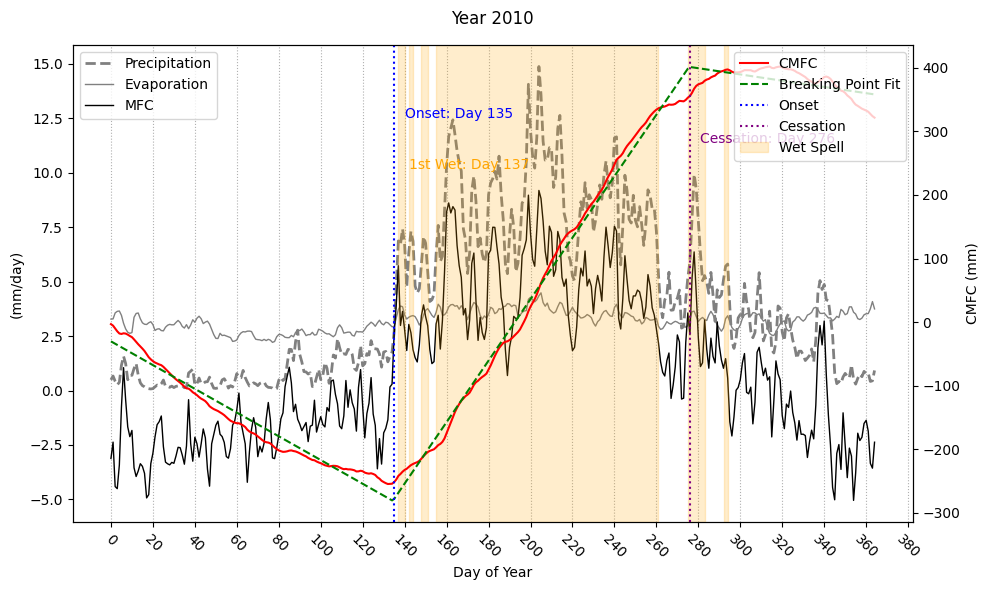

Year 2011: Onset at day 143, Cessation at day 269, First wet spell at day 146


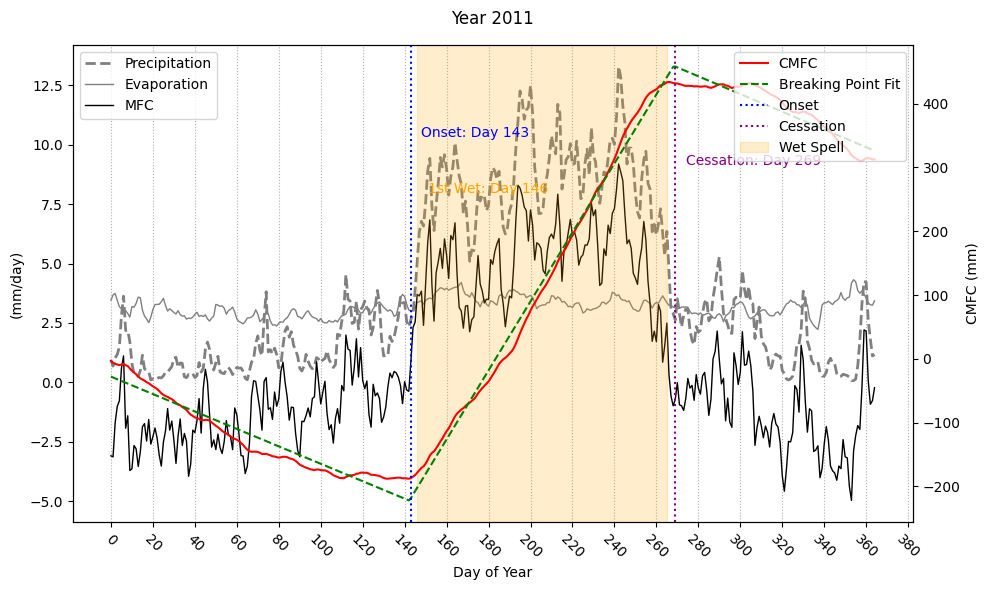

Year 2012: Onset at day 146, Cessation at day 274, First wet spell at day 149


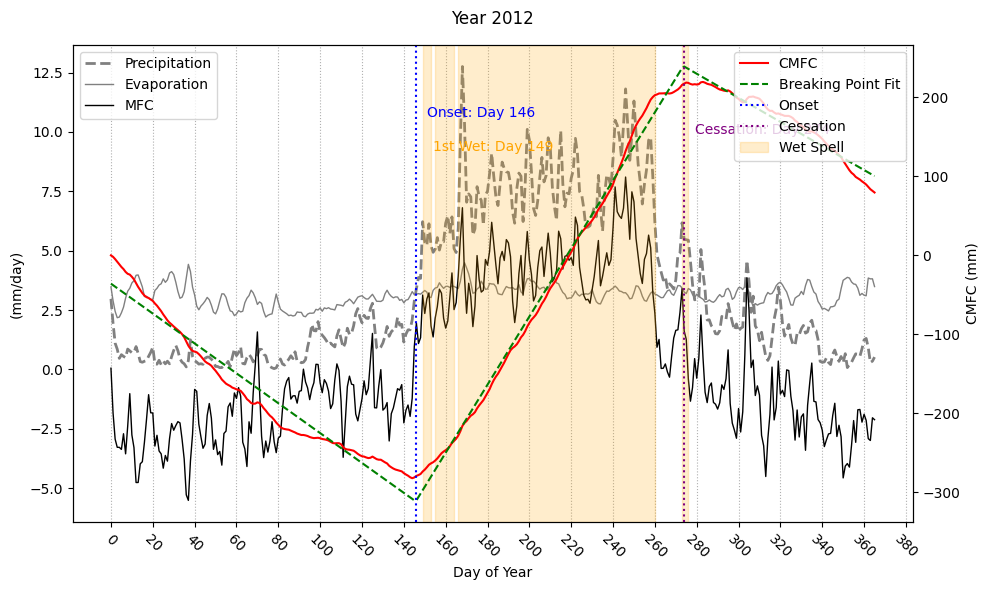

Year 2013: Onset at day 131, Cessation at day 281, First wet spell at day 142


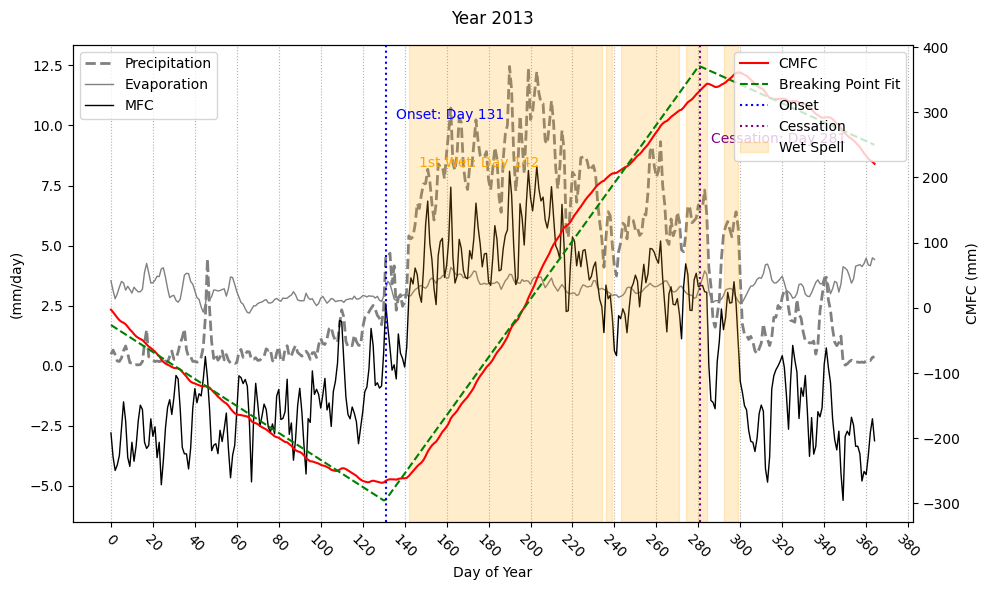

Year 2014: Onset at day 145, Cessation at day 273, First wet spell at day 156


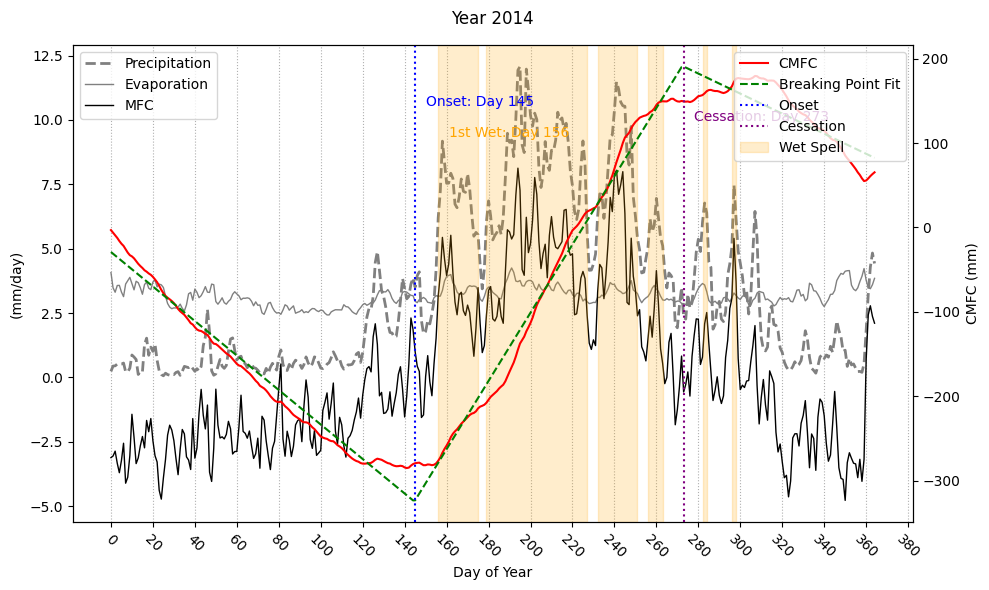

Year 2015: Onset at day 135, Cessation at day 269, First wet spell at day 135


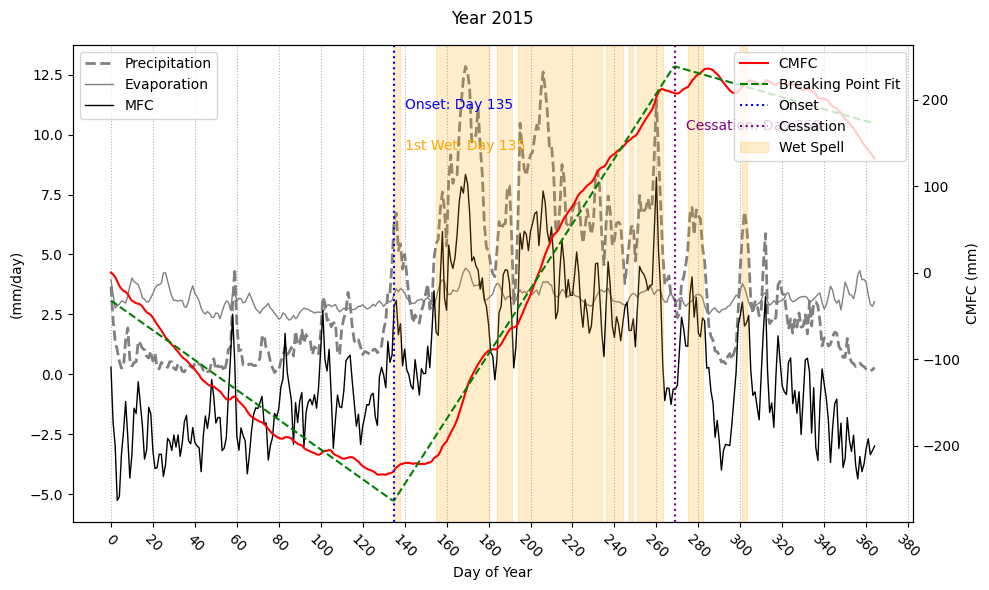

Year 2016: Onset at day 134, Cessation at day 271, First wet spell at day 137


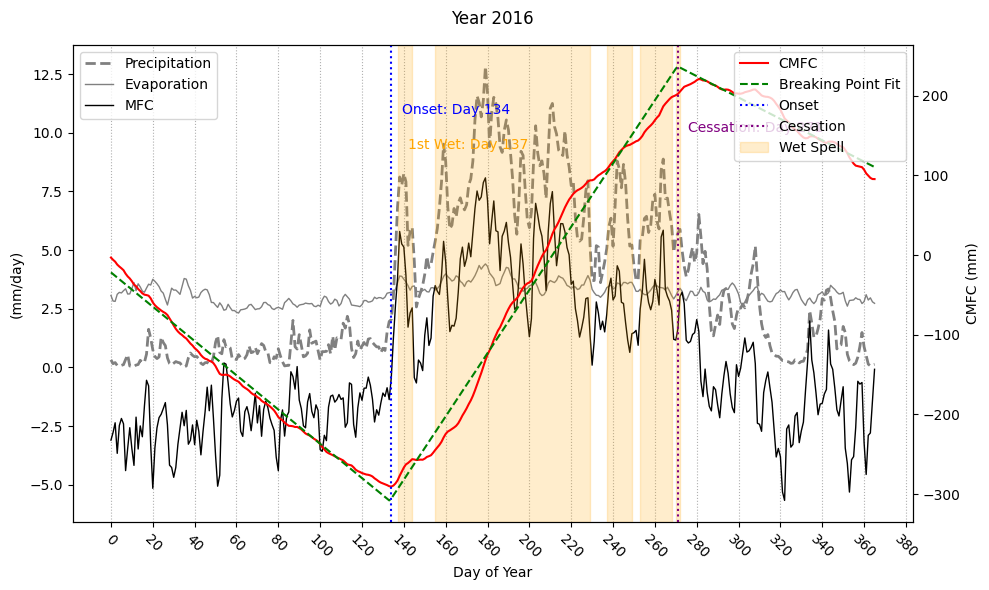

Year 2017: Onset at day 134, Cessation at day 279, First wet spell at day 145


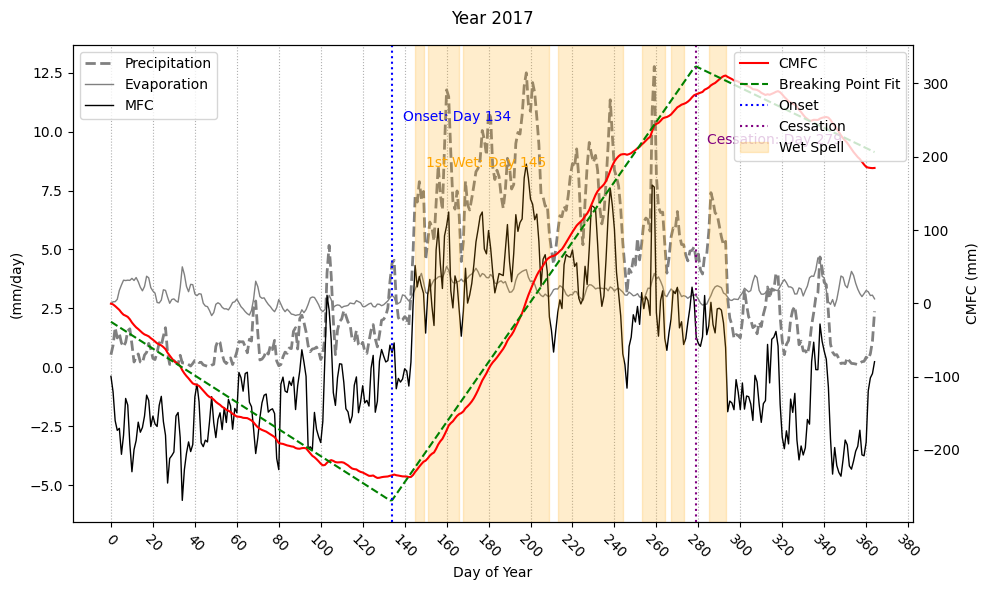

KeyboardInterrupt: 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.ticker as ticker
import os
from matplotlib import rcParams

# Set up directory for saving images
output_dir = "monsoon_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Set plot parameters
rcParams['figure.figsize'] = [10, 6]
rcParams['font.size'] = 10
rcParams['axes.titlesize'] = 12
rcParams['axes.titlepad'] = 12

# Data Loading Functions
def get_file(region, var, year):
    datadir = "http://clima-dods.ictp.it/Users/tompkins/monsoons/data/"
    if region == "india":
        file = datadir + var + "_" + str(year) + "_asia_sn10_30_we60_100.nc"
    url = (file + '#mode=bytes')
    dset = Dataset(url)
    return dset

def get_data(dlist, var, fldname, sf=1, year=2000):
    region = "india"
    ds = get_file(region, var, year)
    fld = np.squeeze(ds[fldname]) * sf
    dlist.append({"var": var, "data": fld, "year": year})
    return dlist

# Plotting Function
def plot_year(dlist, year, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    lstyles = ["dashed", "solid", "solid"]
    lwidths = [2, 1, 1]
    lcols = ["grey", "grey", "black"]
    tick_spacing = 20
    labels = {"evap": "Evaporation", "prec": "Precipitation", "vimd": "MFC"}
    
    for ivar, var in enumerate(dlist):
        ax.plot(var["data"],
                linestyle=lstyles[ivar],
                linewidth=lwidths[ivar],
                color=lcols[ivar],
                label=labels[var["var"]])
    
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("(mm/day)")
    ax.set_title(f"Year {year}", pad=15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xticks(rotation=-45)
    ax.xaxis.grid(linestyle="dotted")
    ax.legend(loc='upper left')
    return fig, ax

# Wet Spell Detection Function
def find_wet_spells(precip_data, threshold=5, min_consecutive=3):
    """Find periods with consecutive days above precipitation threshold"""
    wet_days = precip_data > threshold
    wet_spells = []
    current_spell = []
    
    for i, is_wet in enumerate(wet_days):
        if is_wet:
            current_spell.append(i)
        else:
            if len(current_spell) >= min_consecutive:
                wet_spells.append(current_spell)
            current_spell = []
    
    # Add the last spell if it meets criteria
    if len(current_spell) >= min_consecutive:
        wet_spells.append(current_spell)
    
    return wet_spells

# Onset and Cessation Detection
def piecewise_polyfit(x, y, break_point):
    x1 = np.array(x[:break_point])
    x2 = np.array(x[break_point:])
    y1 = np.array(y[:break_point])
    y2 = np.array(y[break_point:])
    
    coeff1 = np.polyfit(x1, y1, 1)
    coeff2 = np.polyfit(x2, y2, 1)
    
    ypred1 = np.polyval(coeff1, x1)
    ypred2 = np.polyval(coeff2, x2)
    ypred = np.concatenate((ypred1, ypred2))
    
    rss = np.sum((y - ypred) ** 2)
    return ypred, rss

def find_changepoints(x, y):
    min_rss = np.inf
    best_breaks = [0, 0]
    best_ypred = None
    
    # Find onset (first break point between days 50-150)
    for break1 in range(50, 150):
        # Find cessation (second break point after onset)
        for break2 in range(break1+30, len(x)-50):
            # Fit piecewise model with two break points
            x1 = x[:break1]
            x2 = x[break1:break2]
            x3 = x[break2:]
            
            y1 = y[:break1]
            y2 = y[break1:break2]
            y3 = y[break2:]
            
            coeff1 = np.polyfit(x1, y1, 1)
            coeff2 = np.polyfit(x2, y2, 1)
            coeff3 = np.polyfit(x3, y3, 1)
            
            ypred = np.concatenate((
                np.polyval(coeff1, x1),
                np.polyval(coeff2, x2),
                np.polyval(coeff3, x3)
            ))
            
            rss = np.sum((y - ypred) ** 2)
            if rss < min_rss:
                min_rss = rss
                best_breaks = [break1, break2]
                best_ypred = ypred
    
    return best_breaks, best_ypred, min_rss

# Main Analysis (2010-2019)
years = range(2010, 2020)
onset_days = []
cessation_days = []
wet_spell_stats = []

for year in years:
    try:
        # Load Data
        dlist = []
        fldnames = ["tp", "e", "vimd"]
        vars = ["prec", "evap", "vimd"]
        sf = [1, -1, 1]
        
        for ivar, var in enumerate(vars):
            dlist = get_data(dlist, vars[ivar], fldnames[ivar], sf=sf[ivar], year=year)
        
        # Extract precipitation data
        precip_data = dlist[0]["data"]
        
        # Wet Spell Analysis
        wet_spells = find_wet_spells(precip_data)
        if wet_spells:
            first_wet_spell = wet_spells[0]
            wet_spell_start = first_wet_spell[0]
            wet_spell_intensity = np.mean(precip_data[first_wet_spell])
            wet_spell_duration = len(first_wet_spell)
            
            # Find last wet spell (for cessation)
            last_wet_spell = wet_spells[-1]
            wet_spell_end = last_wet_spell[-1]
        else:
            wet_spell_start = np.nan
            wet_spell_intensity = np.nan
            wet_spell_duration = 0
            wet_spell_end = np.nan
        
        wet_spell_stats.append({
            'year': year,
            'start': wet_spell_start,
            'end': wet_spell_end,
            'intensity': wet_spell_intensity,
            'duration': wet_spell_duration,
            'n_spells': len(wet_spells)
        })
        
        # Extract CMFC
        cmfc = get_data([], var="cum_vimd", fldname="vimd", year=year)[0]["data"]
        
        # Detect Onset and Cessation
        x = list(range(len(cmfc)))
        breaks, ypred_best, rss = find_changepoints(x, cmfc)
        day_onset, day_cessation = breaks
        onset_days.append(day_onset)
        cessation_days.append(day_cessation)
        
        print(f"Year {year}: Onset at day {day_onset}, Cessation at day {day_cessation}, First wet spell at day {wet_spell_start}")
        
        # Plot Monsoon Analysis
        fig, ax = plot_year(dlist, year)
        ax2 = ax.twinx()
        ax2.plot(cmfc, label="CMFC", color="red")
        ax2.plot(x, ypred_best, color="green", linestyle="--", label="Breaking Point Fit")
        ax2.axvline(day_onset, color="blue", linestyle=":", label="Onset")
        ax2.axvline(day_cessation, color="purple", linestyle=":", label="Cessation")
        
        # Mark wet spells
        for spell in wet_spells:
            ax2.axvspan(spell[0], spell[-1], color='orange', alpha=0.2, 
                       label='Wet Spell' if spell == wet_spells[0] else "")
        
        ax2.text(day_onset + 5, np.max(cmfc) * 0.8, f"Onset: Day {day_onset}", color="blue")
        ax2.text(day_cessation + 5, np.max(cmfc) * 0.7, f"Cessation: Day {day_cessation}", color="purple")
        if not np.isnan(wet_spell_start):
            ax2.text(wet_spell_start + 5, np.max(cmfc) * 0.6, 
                    f"1st Wet: Day {wet_spell_start}", color="orange")
        
        ax2.set_ylabel("CMFC (mm)")
        ax2.legend(loc='upper right')
        
        # Simplified title
        #plt.title("Monsoon Transition Points\n"
                # "Green Dashed: Break Points | Blue: Onset | Purple: Cessation", 
                # pad=15, fontsize=11)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"monsoon_analysis_{year}.png"), dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error processing year {year}: {str(e)}")
        onset_days.append(np.nan)
        cessation_days.append(np.nan)
        wet_spell_stats.append({
            'year': year,
            'start': np.nan,
            'end': np.nan,
            'intensity': np.nan,
            'duration': np.nan,
            'n_spells': np.nan
        })

# Time Series Analysis
valid_years = [y for y, d in zip(years, onset_days) if not np.isnan(d)]
valid_onset = [d for d in onset_days if not np.isnan(d)]
valid_cessation = [d for d in cessation_days if not np.isnan(d)]
valid_wet_starts = [s['start'] for s in wet_spell_stats if not np.isnan(s['start'])]
valid_wet_ends = [s['end'] for s in wet_spell_stats if not np.isnan(s['end'])]
valid_wet_years = [s['year'] for s in wet_spell_stats if not np.isnan(s['start'])]

# Calculate statistics
onset_mean = np.mean(valid_onset)
onset_std = np.std(valid_onset)
cessation_mean = np.mean(valid_cessation)
cessation_std = np.std(valid_cessation)
wet_mean = np.mean(valid_wet_starts)
wet_std = np.std(valid_wet_starts)
wet_end_mean = np.mean(valid_wet_ends)
wet_end_std = np.std(valid_wet_ends)

# Create time series plot
plt.figure(figsize=(12, 6))
plt.plot(valid_years, valid_onset, 'b-o', label='Onset Day')
plt.plot(valid_years, valid_cessation, 'm-^', label='Cessation Day')
plt.plot(valid_wet_years, valid_wet_starts, 'r-s', label='First Wet Spell')
plt.plot(valid_wet_years, valid_wet_ends, 'g-d', label='Last Wet Spell')

# Add mean lines
plt.axhline(onset_mean, color='blue', linestyle='--', alpha=0.5)
plt.axhline(cessation_mean, color='purple', linestyle='--', alpha=0.5)
plt.axhline(wet_mean, color='red', linestyle='--', alpha=0.5)
plt.axhline(wet_end_mean, color='green', linestyle='--', alpha=0.5)

plt.xlabel("Year")
plt.ylabel("Day of Year")
plt.title("Monsoon Timing Variations (2010-2019)\n"
         "Annual changes in monsoon start and end dates", 
         pad=15)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend.loc('best')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "monsoon_timing_timeseries.png"), dpi=300)
plt.show()

# Create monsoon duration plot
monsoon_durations = [cess - onset for onset, cess in zip(valid_onset, valid_cessation)]
duration_mean = np.mean(monsoon_durations)
duration_std = np.std(monsoon_durations)

plt.figure(figsize=(10, 6))
plt.bar(valid_years, monsoon_durations, color='skyblue', edgecolor='black')
plt.axhline(duration_mean, color='k', linestyle='--', label=f'Mean: {duration_mean:.1f}±{duration_std:.1f} days')
plt.xlabel("Year")
plt.ylabel("Duration (days)")
plt.title("Monsoon Season Duration (2010-2019)\n"
         "Total days between onset and cessation each year", 
         pad=15)
plt.grid(True, axis='y', linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "monsoon_duration.png"), dpi=300)
plt.show()

# Print statistics
print("\nSUMMARY STATISTICS (2010-2019)")
print("="*50)
print(f"{'Onset Day Statistics':^50}")
print(f"{'Mean:':<20}{onset_mean:.1f} days")
print(f"{'Std Dev:':<20}{onset_std:.1f} days")
print(f"{'Range:':<20}{min(valid_onset):.0f}-{max(valid_onset):.0f} days")
print("\n" + f"{'Cessation Day Statistics':^50}")
print(f"{'Mean:':<20}{cessation_mean:.1f} days")
print(f"{'Std Dev:':<20}{cessation_std:.1f} days")
print(f"{'Range:':<20}{min(valid_cessation):.0f}-{max(valid_cessation):.0f} days")
print("\n" + f"{'Monsoon Duration Statistics':^50}")
print(f"{'Mean:':<20}{duration_mean:.1f} days")
print(f"{'Std Dev:':<20}{duration_std:.1f} days")
print(f"{'Range:':<20}{min(monsoon_durations):.0f}-{max(monsoon_durations):.0f} days")
print("\n" + f"{'Wet Spell Statistics':^50}")
print(f"{'Mean Start:':<20}{wet_mean:.1f} days")
print(f"{'Mean End:':<20}{wet_end_mean:.1f} days")
print("="*50)